In [1]:
import pandas as pd
base = pd.read_csv('../dataset/dataset_train.csv')
base = base.dropna()

In [2]:
from sklearn.preprocessing import MinMaxScaler
scaler_price = MinMaxScaler()
base[['sold_price']] = scaler_price.fit_transform(base[['sold_price']])

In [3]:
base

,negotiation_date,sold_price,product
0,07/01/2014,0.233329,Polpa Cítrica
1,08/01/2014,0.222386,Polpa Cítrica
2,09/01/2014,0.214286,Polpa Cítrica
3,10/01/2014,0.255714,Polpa Cítrica
4,11/01/2014,0.151014,Polpa Cítrica
...,...,...,...
1632,26/07/2019,0.255843,Polpa Cítrica
1633,27/07/2019,0.250000,Polpa Cítrica
1634,29/07/2019,0.228571,Polpa Cítrica
1635,30/07/2019,0.292857,Polpa Cítrica


In [4]:
base = base.iloc[:, 1].values

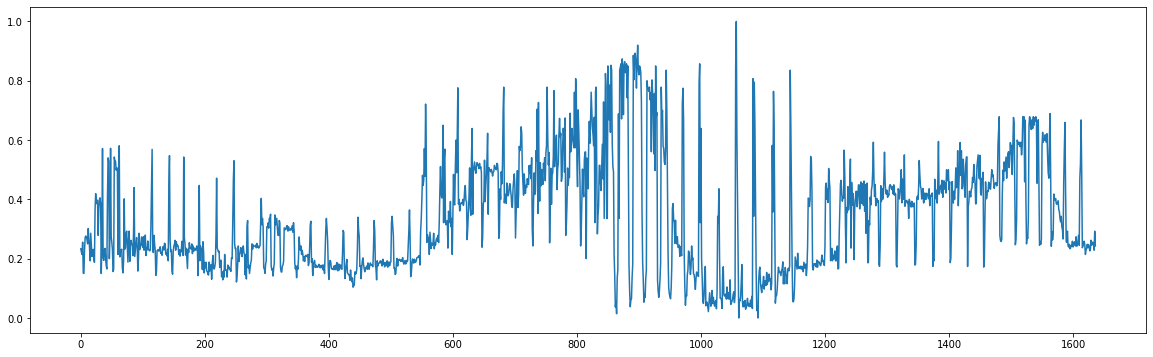

In [5]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20,6))
plt.plot(base)
plt.show()

In [6]:
import numpy as np
def proximo_batch(treino):
    # Seleciona um número aleatório dentro dos índices da base
    inicio = np.random.randint(0,len(treino)-31)
    # Seleciona dentro do conjunto teste o X_test
    X_treino = treino[inicio: inicio + 30].reshape(1,30,1)
    # Seleciona dentro do conjunto teste o y_test
    y_treino = treino[inicio+1: inicio + 31].reshape(1,30,1)
    return X_treino, y_treino

X_teste = base[-31:-1].reshape(1,30,1)
y_teste = base[-30:].reshape(1,30,1)


In [7]:
def init_batches():
    X_batches = []
    y_batches = []
    for i in range(100):
        X_batch, y_batch = proximo_batch(base[:-31])
        X_batches.append(X_batch[0])
        y_batches.append(y_batch[0])
    X_batches = np.array(X_batches)
    y_batches = np.array(y_batches)
    return X_batches, y_batches

In [8]:
periodos = 30 # de quantos em quantos periodos sao os dados ()
previsao_futura = 1 # saber um periodo

X = base[0:(len(base) - (len(base) % periodos))]
X_batches = X.reshape(-1, periodos, 1)
y = base[1:(len(base) - (len(base) % periodos)) + previsao_futura]
y_batches = y.reshape(-1, periodos, 1)

X_teste = base[-(periodos + previsao_futura):]
X_teste = X_teste[:periodos]
X_teste = X_teste.reshape(-1, periodos, 1)
y_teste = base[-(periodos):]
y_teste = y_teste.reshape(-1, periodos, 1)

In [45]:
X_batches.shape, y_batches.shape, X_teste.shape, y_teste.shape

((54, 30, 1), (54, 30, 1), (1, 30, 1), (1, 30, 1))

In [9]:
import tensorflow as tf
tf.random.set_seed(42)

tf.__version__

'2.4.1'

In [10]:
entradas = 1
neuronios_oculta = 350
neuronios_saida = 1

# Usando RNN Simples

In [11]:
class Model(tf.keras.Model):
    def __init__(self):
        super().__init__()
        self.rnn = tf.keras.layers.LSTM(units = neuronios_oculta, activation = 'relu', return_sequences = True, kernel_initializer=tf.keras.initializers.GlorotNormal())
        self.dense = tf.keras.layers.Dense(units = neuronios_saida, kernel_initializer=tf.keras.initializers.GlorotNormal())
    
    def call(self, inputs):
        x = self.rnn(inputs)
        x = self.dense(x)

        return x

In [12]:
model = Model()
otimizador = tf.keras.optimizers.Adam(learning_rate = 0.001)

for epoca in range(1000):
    X_batches, y_batches = proximo_batch(base[:-31])
    with tf.GradientTape() as tape:
        out = model(X_batches)
        erro = tf.keras.losses.mean_squared_error(out, y_batches)
    
    gradientes = tape.gradient(erro, model.trainable_variables)
    otimizador.apply_gradients(zip(gradientes, model.trainable_variables))

    if epoca % 100 == 0:
        print(epoca + 1, ' erro: ', tf.reduce_mean(erro).numpy())

1  erro:  0.4562265439558334
101  erro:  0.03797957714148577
201  erro:  0.008507942724150085
301  erro:  0.00981596220421485
401  erro:  0.0038085858745186434
501  erro:  0.003477952244363122
601  erro:  0.006199264308807935
701  erro:  0.008191102316787335
801  erro:  0.008719464550238322
901  erro:  0.017048302164415528


In [13]:
previsoes = model(X_teste)
previsoes = scaler_price.inverse_transform(previsoes[0])

In [14]:
previsoes

array([[333.53731751],
       [352.73752332],
       [343.3463496 ],
       [344.93283451],
       [329.32691991],
       [434.97394741],
       [472.514714  ],
       [550.52017093],
       [473.60235572],
       [349.87635136],
       [337.50334203],
       [347.06768811],
       [349.31953371],
       [343.24738204],
       [327.46988058],
       [333.14762235],
       [335.91560543],
       [342.12471366],
       [336.79586172],
       [340.91705501],
       [337.6350832 ],
       [330.17786562],
       [331.37346625],
       [346.13275349],
       [338.94385815],
       [341.05693221],
       [342.8007555 ],
       [339.90793645],
       [329.14440155],
       [358.77667189]])

In [15]:
import numpy as np
y_teste2 = np.ravel(scaler_price.inverse_transform(y_teste[0]))

In [16]:
y_teste2

array([316.88, 325.  , 340.  , 316.67, 475.  , 508.5 , 612.5 , 490.  ,
       310.94, 314.  , 325.  , 326.25, 317.31, 295.  , 305.83, 309.44,
       318.95, 310.94, 318.33, 313.24, 303.33, 306.67, 328.57, 316.67,
       321.67, 324.09, 320.  , 305.  , 350.  , 315.  ])

In [17]:
previsoes2 = np.ravel(previsoes)

In [18]:
previsoes2

array([333.53731751, 352.73752332, 343.3463496 , 344.93283451,
       329.32691991, 434.97394741, 472.514714  , 550.52017093,
       473.60235572, 349.87635136, 337.50334203, 347.06768811,
       349.31953371, 343.24738204, 327.46988058, 333.14762235,
       335.91560543, 342.12471366, 336.79586172, 340.91705501,
       337.6350832 , 330.17786562, 331.37346625, 346.13275349,
       338.94385815, 341.05693221, 342.8007555 , 339.90793645,
       329.14440155, 358.77667189])

In [19]:
print(np.sqrt(
        np.square(
            np.subtract(y_teste2, previsoes2)).mean()))

56.008776768338386


In [20]:
from sklearn.metrics import mean_absolute_error
mae = mean_absolute_error(y_teste2, previsoes2)
mae

39.80423091554645

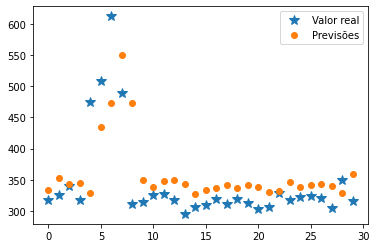

In [21]:
plt.plot(y_teste2, '*', markersize = 10, label = 'Valor real')
plt.plot(previsoes2, 'o', label = 'Previsões')
plt.legend()

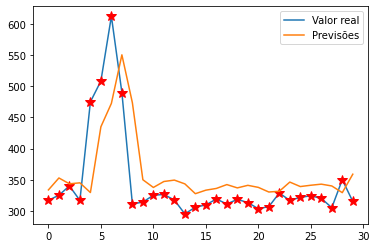

In [22]:
plt.plot(y_teste2, label = 'Valor real')
plt.plot(y_teste2, 'w*', markersize = 10, color = 'red')
plt.plot(previsoes2, label = 'Previsões')
plt.legend()

# Usando LSTM

In [ ]:
class Model(tf.keras.Model):
    def __init__(self):
        super().__init__()
        self.lstm = tf.keras.layers.LSTM(units = neuronios_oculta, activation = 'relu', return_sequences = True)
        self.dense = tf.keras.layers.Dense(units = neuronios_saida)
    
    def call(self, inputs):
        x = self.lstm(inputs)
        x = self.dense(x)

        return x

In [ ]:
model = Model()
otimizador = tf.keras.optimizers.Adam(learning_rate = 0.001)

for epoca in range(1000):
    with tf.GradientTape() as tape:
        out = model(X_batches)
        erro = tf.keras.losses.mean_squared_error(out, y_batches)
    
    gradientes = tape.gradient(erro, model.trainable_variables)
    otimizador.apply_gradients(zip(gradientes, model.trainable_variables))

    if epoca % 100 == 0:
        print(epoca + 1, ' erro: ', tf.reduce_mean(erro).numpy())

In [ ]:
previsoes = model(X_teste)
previsoes = scaler_price.inverse_transform(previsoes[0])
previsoes

In [ ]:
y_teste2

In [ ]:
print(np.sqrt(
        np.square(
            np.subtract(y_teste2, previsoes2)).mean()))

# Múltiplas camadas LSTM

O construtor para empilhar células com estrutura de RNN deve ser `tf.keras.layers.StackedRNNCells`, que depois deve ser consolidada em uma camada usando o construtor `tf.keras.layers.RNN`, conforme exemplo em https://www.tensorflow.org/api_docs/python/tf/keras/layers/StackedRNNCells#examples

In [ ]:
class Model(tf.keras.Model):
    def __init__(self):
        super().__init__()
        lstms = [tf.keras.layers.LSTMCell(units = neuronios_oculta, activation = 'relu') for _ in range(4)]
        stacked_lstm = tf.keras.layers.StackedRNNCells(cells = lstms)
        self.lstm_layer = tf.keras.layers.RNN(cell = stacked_lstm, return_sequences = True)
        self.dense = tf.keras.layers.Dense(units = neuronios_saida)
    
    def call(self, inputs):
        x = self.lstm_layer(inputs)
        x = self.dense(x)

        return x

In [ ]:
model = Model()
otimizador = tf.keras.optimizers.Adam(learning_rate = 0.001)

for epoca in range(1000):
    with tf.GradientTape() as tape:
        out = model(X_batches)
        erro = tf.keras.losses.mean_squared_error(out, y_batches)
    
    gradientes = tape.gradient(erro, model.trainable_variables)
    otimizador.apply_gradients(zip(gradientes, model.trainable_variables))

    if epoca % 100 == 0:
        print(epoca + 1, ' erro: ', tf.reduce_mean(erro).numpy())

In [ ]:
previsoes = model(X_teste)
previsoes

In [ ]:
plt.plot(y_teste2, label = 'Valor real')
plt.plot(y_teste2, 'w*', markersize = 10, color = 'red')
plt.plot(previsoes2, label = 'Previsões')
plt.legend()

In [ ]:
y_teste2 = np.ravel(y_teste)
previsoes2 = np.ravel(previsoes.numpy())
mae = mean_absolute_error(y_teste2, previsoes2)
mae

In [ ]:
print(np.sqrt(
        np.square(
            np.subtract(y_teste2, previsoes2)).mean()))

In [25]:
file = open('predicted_values.txt').read()

In [30]:
final = {}
final['data'] = []
final['predicao'] = [float(x) for x in file.split(';')]

In [33]:
final['predicao']

[316.9,
 316.82,
 317.13,
 317.21,
 317.31,
 316.95,
 316.06,
 314.14,
 311.7,
 310.0,
 308.82,
 307.92,
 307.25,
 306.72,
 306.51,
 306.37,
 306.28,
 306.09,
 305.91,
 305.72,
 305.53,
 305.37,
 305.28,
 305.0,
 304.68,
 304.31,
 303.94,
 303.53,
 303.31,
 302.88]

In [34]:
for dia in range(30):
    final['data'].append(str(dia + 1).zfill(2) + '/08/2019')

In [35]:
final

{'data': ['01/08/2019',
  '02/08/2019',
  '03/08/2019',
  '04/08/2019',
  '05/08/2019',
  '06/08/2019',
  '07/08/2019',
  '08/08/2019',
  '09/08/2019',
  '10/08/2019',
  '11/08/2019',
  '12/08/2019',
  '13/08/2019',
  '14/08/2019',
  '15/08/2019',
  '16/08/2019',
  '17/08/2019',
  '18/08/2019',
  '19/08/2019',
  '20/08/2019',
  '21/08/2019',
  '22/08/2019',
  '23/08/2019',
  '24/08/2019',
  '25/08/2019',
  '26/08/2019',
  '27/08/2019',
  '28/08/2019',
  '29/08/2019',
  '30/08/2019'],
 'predicao': [316.9,
  316.82,
  317.13,
  317.21,
  317.31,
  316.95,
  316.06,
  314.14,
  311.7,
  310.0,
  308.82,
  307.92,
  307.25,
  306.72,
  306.51,
  306.37,
  306.28,
  306.09,
  305.91,
  305.72,
  305.53,
  305.37,
  305.28,
  305.0,
  304.68,
  304.31,
  303.94,
  303.53,
  303.31,
  302.88]}

In [38]:
final_data = pd.DataFrame(final).set_index('data')

In [41]:
final_data.index = pd.to_datetime(final_data.index)
final_data

,predicao
data,
2019-01-08,316.90
2019-02-08,316.82
2019-03-08,317.13
2019-04-08,317.21
2019-05-08,317.31
2019-06-08,316.95
2019-07-08,316.06
2019-08-08,314.14
2019-09-08,311.70


<AxesSubplot:xlabel='data'>

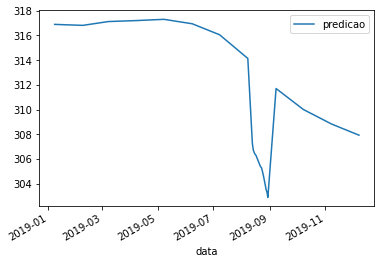

In [42]:
final_data.plot()